<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1mBqrfxng42SgSXvK62V1C67Or_vgrsVm' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

We will be using GPU accelerated Kernel for this tutorial as we would require a GPU to fine-tune BERT.

## Prerequisites:
- Willingness to learn: Growth Mindset is all you need 
- Some basic idea about Tensorflow/Keras 
- Some Python to follow along with the code 

## Initial Set Up

### Install TensorFlow and TensorFlow Model Garden

In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


Cloning the Github Repo for tensorflow models 
-  –depth 1, during cloning, Git will only get the latest copy of the relevant files. It can save you a lot of space and time.

- -b lets us clone a specific branch only.

**Please match it with your tensorflow 2.x version.**

In [2]:
!git clone --depth 1 -b v2.7.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [3]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards, also ignore any ERRORS popping up at this step

**Note**: After installing the required Python packages, you'll need to restart the Colab Runtime Engine 
(Run ---> Restart and clear all cell outputs...)

**NOTE: ANYTHING BEFORE THIS CELL SHOULD ONLY BE RUN ONCE, ONLY DURING THE INITIAL SETUP**

## Some Initial Imports and Checks

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [6]:
import pandas as pd
train_df = pd.read_csv('BERT_DATA_DIR/train.csv', encoding='latin-1')
valid_df = pd.read_csv('BERT_DATA_DIR/valid.csv', encoding='latin-1')
print(train_df.shape)
print(valid_df.shape)

(45000, 6)
(15000, 6)


In [7]:
train_df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [8]:
valid_df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \nselect *...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\n\n array(\n\t...,<php>,2016-01-01 11:34:09,LQ_EDIT


In [9]:
train_df = train_df.drop(columns=['Title', 'Tags', 'CreationDate'])

In [10]:
valid_df = valid_df.drop(columns=['Title', 'Tags', 'CreationDate'])

In [11]:
train_df.Y = pd.Categorical(train_df.Y)
valid_df.Y = pd.Categorical(valid_df.Y)

In [12]:
train_df['Y_cat_code'] = train_df.Y.cat.codes
valid_df['Y_cat_code'] = valid_df.Y.cat.codes

In [13]:
train_df.head(20)

,Id,Body,Y,Y_cat_code
0,34552656,<p>I'm already familiar with repeating tasks e...,LQ_CLOSE,1
1,34553034,<p>I'd like to understand why Java 8 Optionals...,HQ,0
2,34553174,<p>I am attempting to overlay a title over an ...,HQ,0
3,34553318,"<p>The question is very simple, but I just cou...",HQ,0
4,34553755,<p>I'm using custom floatingactionmenu. I need...,HQ,0
5,34554026,<p>I have defined integer pointer inside the s...,LQ_CLOSE,1
6,34554206,"i want to Disable 2nd Saturday 4th saturday,...",LQ_EDIT,2
7,34554671,I am new to bootstrap and i would like to find...,LQ_EDIT,2
8,34554871,<p>I was able to change theme using <code>this...,HQ,0
9,34554982,I my case I am having two form Form 1 and Form...,LQ_EDIT,2


In [14]:
valid_df.head(20)

,Id,Body,Y,Y_cat_code
0,34552974,I am having 4 different tables like \nselect *...,LQ_EDIT,2
1,34554721,I have two table m_master and tbl_appointment\...,LQ_EDIT,2
2,34555135,<p>I'm trying to extract US states from wiki U...,HQ,0
3,34555448,"I'm so new to C#, I wanna make an application ...",LQ_EDIT,2
4,34555752,basically i have this array:\n\n array(\n\t...,LQ_EDIT,2
5,34557209,<p>I am trying to make a constructor for a der...,LQ_CLOSE,1
6,34557363,I am using c++ in my lesson and for solving a...,LQ_EDIT,2
7,34557587,<p>I'm getting a bit lost in TS re-exports. Sa...,HQ,0
8,34558264,<p>I am trying out the new Fetch API but is ha...,HQ,0
9,34559136,"<pre><code>lt = ['7,777.7', '777.7', '77,777.7...",LQ_CLOSE,1


In [15]:
train_df = train_df.drop(columns=['Y'])
valid_df = valid_df.drop(columns=['Y'])

Text(0.5, 1.0, 'Distribution of question text length in words')

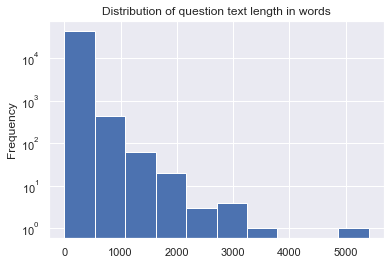

In [16]:
# TRAIN SET 
train_df['Body'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')

Text(0.5, 1.0, 'Distribution of question text length in characters')

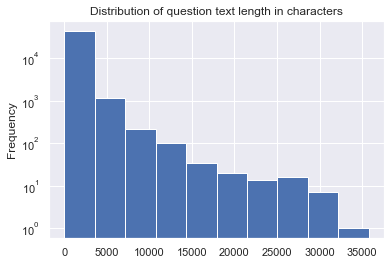

In [17]:
# TRAIN SET
train_df['Body'].apply(lambda x: len(x)).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters')

Text(0.5, 1.0, 'Distribution of question text length in words')

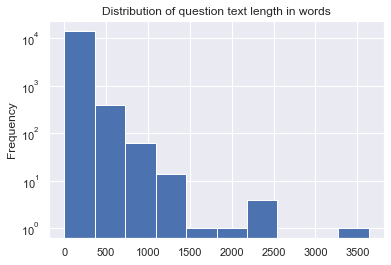

In [18]:
# VALIDATION SET
valid_df['Body'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in words')

# Taming the Data

In [19]:
# we want the dataset to be created and processed on the cpu 
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['Body'].values, train_df['Y_cat_code'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['Body'].values, valid_df['Y_cat_code'].values))
    # lets look at 3 samples from train set
    for text,label in train_data.take(3):
        print(text)
        print(label)


tf.Tensor(b'<p>I\'m already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print "Hello World" to the console every random seconds from 1-5. Unfortunately I\'m in a bit of a rush and don\'t have any code to show so far. Any help would be apriciated.  </p>\n', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int8)
tf.Tensor(b"<p>I'd like to understand why Java 8 Optionals were designed to be immutable.  Is it just for thread-safety?</p>\n", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int8)
tf.Tensor(b'<p>I am attempting to overlay a title over an image - with the image darkened with a lower opacity. However, the opacity effect is changing the overlaying text as well - making it dim. Any fix to this? Here is what is looks like:</p>\n\n<p><a href="https://i.stack.imgur.com/1HzD7.png" rel="noreferrer"><img src="https://i.stack.imgur.com/1HzD7.png" alt="enter image description here"></a></p>\n\n<p>And here 

2021-12-12 16:40:50.175264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
print(len(train_data))
print(len(valid_data))

45000
15000


## Lets BERT: Get the Pre-trained BERT Model from TensorFlow Hub

We will be using the uncased BERT present in the tfhub. In order to prepare the text to be given to the BERT layer, we need to first tokenize our words. The tokenizer here is present as a model asset and will do uncasing for us as well.

Setting all parameters in form of a dictionary so any changes if needed can be made here

In [21]:
# Setting some parameters

config = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':5,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train_data),
          'valid_samples': len(valid_data),
          'train_split':0.1,
          'valid_split': 0.01
         }

In [24]:
# Get BERT layer and tokenizer:
# All details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

OSError: SavedModel file does not exist at: /var/folders/6z/v3dd5g393qb4x_sxw_kvvpcw0000gn/T/tfhub_modules/ce53fe6769d2ac3a260e92555120c54e1aecbea6/{saved_model.pbtxt|saved_model.pb}

## Lets Get That Data Ready: Tokenize and Preprocess Text for BERT

Each line of the dataset is composed of the review text and its label.
Data preprocessing consists of transforming text to BERT input features:
`input_word_ids`, `input_mask`, `segment_ids/input_type_ids`

- **Input Word Ids:** Output of our tokenizer, converting each sentence into a set of token ids.

- **Input Masks:** Since we are padding all the sequences to 128(max sequence length), it is important that we create some sort of mask to make sure those paddings do not interfere with the actual text tokens. Therefore we need a generate input mask blocking the paddings. The mask has 1 for real tokens and 0 for padding tokens. Only real
tokens are attended to.

- **Segment Ids:** For out task of text classification, since there is only one sequence, the segment_ids/input_type_ids is essentially just a vector of 0s. 



Bert was trained on two tasks:
- fill in randomly masked words from a sentence.
- given two sentences,  which sentence came first. 


In [ ]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier
def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
    """
    converts the datapoint into usable features for BERT using the classifier_data_lib

    Parameters:
    text: Input text string
    label: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets

    Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here

    """
    # since we only have 1 sentence for classification purpose, textr_b is None
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # since only 1 example, the index=0
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

### Wrapping the Python Function into a TensorFlow op for Eager Execution

In [ ]:
def create_feature_map(text, label):
    """
    A tensorflow function wrapper to apply the transformation on the dataset.
    Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string

    Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
    """
    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']

    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)

    # the final datapoint passed to the model is of the format a dictionary as x and labels.
    # the dictionary have keys which should obv match

## Let the Data Flow: Creating the final input pipeline using `tf.data`

In [ ]:
# Now we will simply apply the transformation to our train and test datasets
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(create_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec, we can finally see the input datapoint is now converted to the BERT specific input tensor
train_data.element_spec

In [ ]:
# valid data spec
valid_data.element_spec

## Create The Model

There are two outputs from the BERT Layer: 
- A pooled_output of shape [batch_size, 768] with representations for the entire input sequences.  
- A sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context).

For the classification task, we are only concerned with the pooled_output.

In [ ]:
# Building the model, input ---> BERT Layer ---> Classification Head
def create_model():
    
    input_word_ids=tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
    input_mask=tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
    input_type_ids=tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    # for classification we only care about the pooled-output.
    # At this point we can play around with the classification head based on the 
    # downstream tasks and its complexity

    drop = tf.keras.layers.Dropout(config['dropout'])(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

    # inputs coming from the function
    model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
      outputs=output)

    return model

## Let Us Train !

In [ ]:
# Calling the create model function to get the keras based functional model
model = create_model()

In [ ]:
# using adam with a lr of 2*(10^-5), loss as binary cross entropy as only 2 classes and similarly binary accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.PrecisionAtRecall(0.5),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model.summary()

One drawback of the tf hub is that we import the entire module as a layer in keras as a result of which we dont see the parameters and layers in the model summary.

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

The official tfhub page states that
"All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice." Therefore we will go ahead and train teh entire model without freezing anything

In [ ]:
# Train model
# setting low epochs as It starts to overfit with this limited data,
epochs = config['epochs']
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)
run.finish()

### Lets Evaluate

Let us do an evaluation on the validation set and log the scores using weights and biases.

In [ ]:
# Model Evaluation on validation set
evaluation_results = model.evaluate(valid_data,return_dict=True)


### Lets Look at some Graphs

These Graphs will mainly be useful when we are training for more epochs and more data.
All these graphs are actually directly logged on the [wandb dashboard](https://wandb.ai/akshayuppal12/Finetune-BERT-Text-Classification/runs/29thnm00?workspace=user-akshayuppal12) created for this run. To still give out a method to generate graphs explicitly here is some very basic code.

In [ ]:

def create_graphs(history):
    train_accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy'],
    train_losses = history.history['loss'],
    val_losses = history.history['val_loss']
    fig1 = plt.figure()
    plt.plot(train_accuracy, 'r', linewidth=3.0, marker='o')
    plt.plot(val_accuracy, 'b', linewidth=3.0, marker='o')
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    plt.show()

    fig2 = plt.figure()
    plt.plot(train_losses, 'r', linewidth=3.0, marker='o')
    plt.plot(val_losses, 'b', linewidth=3.0, marker='o')
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.show()

Since we just trained for a very limited data and less epoch these graphs generated here are not as 
represenetative, so leaving this here more interms of a place holder for the reader to experiment with.

In [ ]:
create_graphs(history)

### Saving the models and model Versioning

#### W&B Artifacts
For saving the models and making it easier to track different experiments, I will be using wandb.artifacts.
W&B Artifacts are a way to save your datasets and models.

Within a run, there are three steps for creating and saving a model Artifact.

- Create an empty Artifact with wandb.Artifact().
- Add your model file to the Artifact with wandb.add_file().
- Call wandb.log_artifact() to save the Artifact


In [ ]:
# Save model
model.save(f"{config['model_name']}.h5")

# Initialize a new W&B run for saving the model, changing the job_type
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='save')


# Save model as Model Artifact
artifact = wandb.Artifact(name=f"{config['model_name']}", type='model')
artifact.add_file(f"{config['model_name']}.h5")
run.log_artifact(artifact)

# Finish W&B run
run.finish()

[Artifact dashboard](https://wandb.ai/akshayuppal12/Finetune-BERT-Text-Classification/artifacts/model/BERT_EN_UNCASED/48ffa3e14aba242a5113): Model versioning and more.

### Quick Sneak Peek into the W&B Dashboard

**Things to note:**
- Grouping of experiments and runs.
- Visualizations of all training logs and metrics.
- Visualizations for system metrics, could be useful when training on cloud instances or physical GPU machines
- Hyperparmeter tracking in the tabular form.
- Artifacts: Model versioning and storage.

<img src="https://i.imgur.com/CD7iPK1.gif">



Hopefully, this was useful for you, and by now, you have a small kickstart on training and utilizing BERT for a variety of downstream tasks like classification, Named Entity Recognition, Sentence filling, and many more.

You can check out and get the entire code as a notebook and run it on colab from this [Github Repo](https://github.com/au1206/Fine_Tuning_BERT).

If this was helpful, consider sharing it with more people so they can also learn about it.

Coming up Next:
- BERT Annotated Paper
- Write up on Transformers and its workings 

For some annotated, reader-friendly research papers on advanced concepts and tutorials like these please visit https://au1206.github.io/.

If you made it this far, please consider leaving feedback so I can improve and also if you liked it consider upvoting. 

(UPDATE): [BERT Annotated Paper and Beyond...](https://au1206.github.io/annotated%20paper/BERT/)

### References:
W&B usage and intro: https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases 